# Helpmate AI

 The RAG pipeline will consist of the following three layers:
- Embedding Layer
- Search and Rank Layer
- Generation Layer


The first step in the pipeline is to build the vector store. As illustrated in the image below, this step involves ingesting the documents, processing them to create individual chunks and passing these to an embedding model to create individual vector representations of the text. The second layer in the pipeline is the search and rank layer, which will perform a semantic similarity search on the knowledge bank based on the query and retrieve the top results. The output of this layer is the top K closest documents or chunks for the query and their indices.



The last layer is the generation layer, which receives the results of the previous layer, which contains the top retrieved search results, the original user query and a well-constructed prompt to the LLM. These inputs allow the LLM to generate a more coherent answer that is relevant to the user query with information/relevant chunks stored in the knowledge base.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 1. <font color = red> Install and Import the Required Libraries

In [2]:
# Install all the required libraries

!pip install pdfplumber tiktoken openai chromaDB sentence-transformers -q
# !pip install google-generativeai pinecone-client pdfplumber openai sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import openai
import chromadb
from google.colab import userdata

In [4]:
openAPIKey = userdata.get('OpenAIKey')
openai.api_key = openAPIKey

First Step:

Embedding Layer

Embedding layer - is not straight forward. First from text corpus to processing documents -- has a lot of pre-processing.

we process the documents (in this case, the documents pertain to the insurance domain) to extract the text, split it into smaller chunks and then pass them to the embedding model.

## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

#### <font color = red> 2.1 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [5]:
# Define the path where all pdf documents are present
# pdf_path = "/content/drive/MyDrive/GenAI - upGrad/HelpmateAI/HelpMate AI Codes/Assignment - demo - upGrad/Helpmate AI - Assignment/India - Interim Budget Speech of Finance (1996-2024)"
# Define the path where all pdf documents are present

# pdf_path = "/content/drive/My Drive/HelpMate AI Codes/Policy Documents"
# pdf_path = "/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/Week 3/Policy Documents"
# pdf_path = "/content/drive/MyDrive/GenAI - upGrad/HelpmateAI/HelpMate AI Codes/Assignment - demo - upGrad/Policy+Documents/"
pdf_path = "/content/drive/MyDrive/GenAI - upGrad/HelpmateAI/HelpMate AI Codes/Helpmate AI - Assignment"

In [6]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [7]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [8]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [9]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [10]:
insurance_pdfs_data.shape

(64, 3)

In [11]:
insurance_pdfs_data.sample(2)

,Page No.,Page_Text,Document Name
39,Page 40,Section E - Reinstatement Article 1 - Reinstat...,Principal-Sample-Life-Insurance-Policy.pdf
52,Page 53,Section B - Member Accidental Death and Dismem...,Principal-Sample-Life-Insurance-Policy.pdf


In [12]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [13]:
insurance_pdfs_data.sample(2)

,Page No.,Page_Text,Document Name,Text_Length
37,Page 38,Section D - Continuation Article 1 - Member Li...,Principal-Sample-Life-Insurance-Policy.pdf,317
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299


In [14]:
max(insurance_pdfs_data['Text_Length'])

462

To ignore the blank pages with minimum of 10 words, we use the following code to ignore the blank page -- which has minimun of 10 words or only has header or footer

In [15]:
# Retain only the rows with a text length of at least 10
insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176


In [16]:
# Store the metadata for each page in a separate column
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [ ]:
insurance_pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [17]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [18]:
# Define the path where chroma collections will be stored

# chroma_data_path = '/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/Week 3/ChromaDB_Data'

# Define the path where chroma collections will be stored

# chroma_data_path = '/content/drive/MyDrive/GenAI - upGrad/HelpmateAI/HelpMate AI Codes/ChromaDB_Path/'
chroma_data_path = '/content/drive/MyDrive/GenAI - upGrad/HelpmateAI/HelpMate AI Codes/Helpmate AI - Assignment/ChromaDB_Path'

In [19]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [20]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [21]:
from chromadb.utils import embedding_functions

sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [23]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

# insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=sentence_transformer_ef)

In [24]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [25]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.02592192403972149,
   0.0477774553000927,
   0.05585773289203644,
   0.042397499084472656,
   0.05814302712678909,
   0.10849820077419281,
   0.028890959918498993,
   -0.00977777224034071,
   -0.08766447752714157,
   0.027251573279500008,
   0.03773782029747963,
   0.041594844311475754,
   -0.013699034228920937,
   -0.06046957150101662,
   -0.09530659019947052,
   -0.03552006930112839,
   -0.050234198570251465,
   0.013877589255571365,
   -0.038272324949502945,
   0.03651925548911095,
   0.009495585225522518,
   0.03799034655094147,
   -0.06191490218043327,
   -0.03339477255940437,
   0.032034892588853836,
   0.0003445717738941312,
   0.03497115522623062,
   -0.04820391163229942,
   0.021832752972841263,
   0.00023780723859090358,
   0.004617232829332352,
   -0.036271125078201294,
   -0.0349435955286026,
   0.04148414358496666,
   0.033913470804691315,
   -0.008206167258322239,
   -0.04822537675499916,
   -0.0033177563454955816,
   -0.025191

In [26]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [27]:
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

once the text in the documents has been pre-processed and chunked, the next step is to generate vector representations using a suitable text embedding model. So far, you have been using the sentence transformer library and, specifically, the all-MiniLM-L6-V2 model to generate vector embeddings. For this demonstration, the embedding model being used is OpenAI's embedding model - specifically, the ada002 v2 model, which embeds text into a vector of 1,536 dimensions. We are using ChromaDB’s utilities functions to generate the vector embeddings through OpenAI’s model. For more information on this, refer to :

https://docs.trychroma.com/embeddings#openai


Once the embeddings have been generated, the next step is to store them in the vector database, which is ChromaDB. As covered in the previous sessions on ChromaDB, you need to first create the Chroma collections before you can start adding documents. Akshay used the get_or_create_collections method, which will create a collection if not already present, and fetch it from your system if it has been created and stored previously. Next, since we are using OpenAI embeddings and not Chroma's default embedding, you need to also pass your embedding function as an argument while creating the collection. Finally, the information that includes the document list, text and metadata information is passed to the chroma collection. Additionally, Akshay also created a Chroma collection to serve as cache, which we will explore in the upcoming segment.

https://medium.com/@azhar.sayyad6/a-step-by-step-guide-to-parsing-pdfs-using-the-pdfplumber-library-in-python-c12d94ae9f07#:~:text=pdfplumber%20is%20a%20powerful%20library,data%20analysis%20and%20automation%20tasks.

Semantic Search Layer

As with any good system design, we need to consider a scenario when the application is scaled - suppose the number of documents increases or multiple users are using the application. Such a scenario opens up multiple concerns about the system’s performance

- How will the system handle multiple queries simultaneously?
- Is there scope to improve the system’s overall performance in search and retrieval?



The first concern can be solved by using vector databases and scaling up the compute units (clusters/server) for the application. For the second concern, an improvement to the overall system design is required which can be achieved by implementing a cache collection in the vector database that stores previous queries and their results in the vector database. Let’s hear more on this from Akshay in the video below.

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

 the design considerations for creating a cache layer in the semantic search system.

 Documnet query --
 - first search in cache
  - if find return top k closeset / chunks of k documents the results
  - if not find search in main vector db
    - store the new query in cache
      - if similar query occurs in future, it's easy to return answer
    - search and index on the main vector db and return top k closeset / chunks of k documents the results
    


In [29]:
# Read the user query

query = input()

What are the default benefits and provisions of the Group Policy?


In [30]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [31]:
cache_results

{'ids': [[]],
 'distances': [[]],
 'metadatas': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None}

In [32]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
results.items()

dict_items([('ids', [['13', '16', '14', '39', '3', '1', '28', '30', '18', '27']]), ('distances', [[0.8645807048829774, 0.8843736066203847, 0.9797316997133682, 1.0185734360786771, 1.0266768115139477, 1.051857798987099, 1.0616972982035096, 1.1031166818719416, 1.1138285765667664, 1.1176436303510577]]), ('metadatas', [[{'Page_No.': 'Page 16', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 19', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 17', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 42', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 6', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 3', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 31', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 33', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 21', 'Poli

In [33]:
# Implementing Cache in Semantic Search

# Set a threshold for cache searchA
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        if key != 'embeddings':
          for i in range(10): # Top 10 variable, we can also put as 25 for top_n
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [34]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 16', 'Policy_Name': 'Princi...",PART II - POLICY ADMINISTRATION Section A - Co...,0.864581,13
1,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi...",T he Principal has complete discretion to cons...,0.884374,16
2,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.979732,14
3,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",Section F - Individual Purchase Rights Article...,1.018573,39
4,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,1.026677,3
5,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.051858,1
6,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",Scheduled Benefit in force for the Member befo...,1.061697,28
7,"{'Page_No.': 'Page 33', 'Policy_Name': 'Princi...",a . In no event will Dependent Life Insurance ...,1.103117,30
8,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,1.113829,18
9,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...","(6) If, on the date a Member becomes eligible ...",1.117644,27


With different Query

In [35]:
# Read the user query

query2 = input()

what does it mean by 'the later of the Date of Issue'?


In [36]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results2 = cache_collection.query(
    query_texts=query2,
    n_results=1
)

In [37]:
cache_results2

{'ids': [['What are the default benefits and provisions of the Group Policy?']],
 'distances': [[0.5436162853275909]],
 'metadatas': [[{'distances0': '0.8645807048829774',
    'distances1': '0.8843736066203847',
    'distances2': '0.9797316997133682',
    'distances3': '1.0185734360786771',
    'distances4': '1.0266768115139477',
    'distances5': '1.051857798987099',
    'distances6': '1.0616972982035096',
    'distances7': '1.1031166818719416',
    'distances8': '1.1138285765667664',
    'distances9': '1.1176436303510577',
    'documents0': "PART II - POLICY ADMINISTRATION Section A - Contract Article 1 - Entire Contract This Group Policy, the current Certificate, the attached Policyholder application, and any Member applications make up the entire contract. The Principal is obligated only as provided in this Group Policy and is not bound by any trust or plan to which it is not a signatory party. Article 2 - Policy Changes Insurance under this Group Policy runs annually to the Policy

In [38]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids2 = []
documents2 = []
distances2 = []
metadatas2 = []
results_df2 = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results2['distances'][0] == [] or cache_results2['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query2,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys2 = []
      Values2 = []

      for key, val in results.items():
        if val is None:
          continue
        if key != 'embeddings':
          for i in range(10): # Top 10 variable, we can also put as 25 for top_n
            Keys2.append(str(key)+str(i))
            Values2.append(str(val[0][i]))


      cache_collection.add(
          documents= [query2],
          ids = [query2],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys2, Values2))
      )

      print("Not found in cache. Found in main collection.")

      result_dict2 = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df2 = pd.DataFrame.from_dict(result_dict2)
      results_df2


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results2['distances'][0][0] <= threshold:
      cache_result_dict2 = cache_results2['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict2.items():
          if 'ids' in key:
              ids2.append(value)
          elif 'documents' in key:
              documents2.append(value)
          elif 'distances' in key:
              distances2.append(value)
          elif 'metadatas' in key:
              metadatas2.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df2 = pd.DataFrame({
        'IDs': ids2,
        'Documents': documents2,
        'Distances': distances2,
        'Metadatas': metadatas2
      })


Not found in cache. Found in main collection.


In [39]:
results_df2

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi...",Insurance for which Proof of Good Health is re...,1.200996,26
1,"{'Page_No.': 'Page 27', 'Policy_Name': 'Princi...",I f a Member's Dependent is employed and is co...,1.259137,24
2,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,1.332726,18
3,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",Scheduled Benefit in force for the Member befo...,1.349086,28
4,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,1.359287,33
5,"{'Page_No.': 'Page 34', 'Policy_Name': 'Princi...",provided The Principal has been notified of th...,1.387343,31
6,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",Section D - Claim Procedures Article 1 - Notic...,1.391412,58
7,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",Section B - Effective Dates Article 1 - Member...,1.394463,25
8,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...","(6) If, on the date a Member becomes eligible ...",1.409443,27
9,"{'Page_No.': 'Page 24', 'Policy_Name': 'Princi...",T he Principal may terminate the Policyholder'...,1.421555,21


With different Query 3

In [40]:
# Read the user query

query3 = input()

What happens if a third-party service provider fails to provide the promised goods and services?


In [41]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results3 = cache_collection.query(
    query_texts=query3,
    n_results=1
)

In [42]:
cache_results3

{'ids': [['What are the default benefits and provisions of the Group Policy?']],
 'distances': [[0.4614038126974972]],
 'metadatas': [[{'distances0': '0.8645807048829774',
    'distances1': '0.8843736066203847',
    'distances2': '0.9797316997133682',
    'distances3': '1.0185734360786771',
    'distances4': '1.0266768115139477',
    'distances5': '1.051857798987099',
    'distances6': '1.0616972982035096',
    'distances7': '1.1031166818719416',
    'distances8': '1.1138285765667664',
    'distances9': '1.1176436303510577',
    'documents0': "PART II - POLICY ADMINISTRATION Section A - Contract Article 1 - Entire Contract This Group Policy, the current Certificate, the attached Policyholder application, and any Member applications make up the entire contract. The Principal is obligated only as provided in this Group Policy and is not bound by any trust or plan to which it is not a signatory party. Article 2 - Policy Changes Insurance under this Group Policy runs annually to the Policy

In [43]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids3 = []
documents3 = []
distances3 = []
metadatas3 = []
results_df3 = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results3['distances'][0] == [] or cache_results3['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query3,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys3 = []
      Values3 = []

      for key, val in results.items():
        if val is None:
          continue
        if key != 'embeddings':
          for i in range(10): # Top 10 variable, we can also put as 25 for top_n
            Keys3.append(str(key)+str(i))
            Values3.append(str(val[0][i]))


      cache_collection.add(
          documents= [query3],
          ids = [query3],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys3, Values3))
      )

      print("Not found in cache. Found in main collection.")

      result_dict3 = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df3 = pd.DataFrame.from_dict(result_dict3)
      results_df3


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results3['distances'][0][0] <= threshold:
      cache_result_dict3 = cache_results3['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict3.items():
          if 'ids' in key:
              ids3.append(value)
          elif 'documents' in key:
              documents3.append(value)
          elif 'distances' in key:
              distances3.append(value)
          elif 'metadatas' in key:
              metadatas3.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df3 = pd.DataFrame({
        'IDs': ids3,
        'Documents': documents3,
        'Distances': distances3,
        'Metadatas': metadatas3
      })


Not found in cache. Found in main collection.


In [44]:
results_df3

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.067310,1
1,"{'Page_No.': 'Page 24', 'Policy_Name': 'Princi...",T he Principal may terminate the Policyholder'...,1.369204,21
2,"{'Page_No.': 'Page 23', 'Policy_Name': 'Princi...",Section C - Policy Termination Article 1 - Fai...,1.382593,20
3,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi...",T he Principal has complete discretion to cons...,1.416428,16
4,"{'Page_No.': 'Page 47', 'Policy_Name': 'Princi...","M ember's death, the Death Benefits Payable ma...",1.425472,44
5,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,1.469127,3
6,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",c . a copy of the form which contains the stat...,1.470377,15
7,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,1.498452,14
8,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",Section D - Claim Procedures Article 1 - Notic...,1.498820,58
9,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,1.500066,33


A semantic cache stores the meaning of a query or request instead of only the raw data along with the responses. This can reduce the number of queries the database needs to process by recalling previous queries and their results. The cache system can now circumvent the semantic search layer, which has been the bottleneck of the system, and directly provide responses for the queries that have already been generated before and stored in the cache collection. Now, when the query is passed to the application, its vector representation is generated and then searched in the cache collection first. If the query is not found in the cache collection, the system queries the main collection and finds the top k closest documents or chunks for the query. The results are then returned to the user and, simultaneously, are stored in the cache alongwith the query. Customising and monitoring the cache's performance can also make it more efficient. Since the cache stores previous queries and results, it can quickly provide the results of a query without processing it. As a result, response times can be faster, and users can experience better application performance.

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

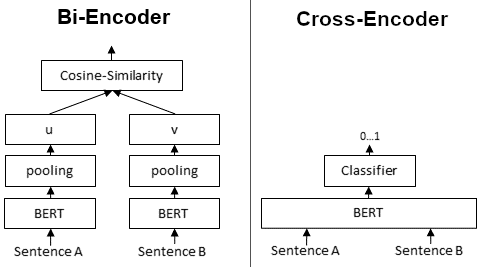

<br>

 the re-ranking stage is the next step in building the semantic search pipeline. So far, in our semantic search application, the system returns the top K documents that contain information relevant to the user’s query. The quality and accuracy of the information contained in these chunks or documents may vary - the system might retrieve documents that are not quite relevant to the search query. The purpose of the re-ranking layer is to sift through these top K results, verify the accuracy of the results in terms of the query and rank them or assign an importance score to these results for the query. Here are some of the benefits of using re-ranking in generative search:
- Improved accuracy and relevance of the generated results
- Reduced amount of irrelevant or inaccurate information presented to the user
- More personalised and informative search results
- Ability to tailor the search results to specific tasks or domains



Traditionally, many methods of re-rank methods have been used in search such as Reciprocal Rank Fusion (RRF), hybrid search methods and cross-encoder models. For this project, we will focus on the popular method of using cross-encoders for our re-ranking task. The image below illustrates the re-ranking component once the search results have been collected by the semantic search layer.

In [45]:
results_df.head()

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 16', 'Policy_Name': 'Princi...",PART II - POLICY ADMINISTRATION Section A - Co...,0.864581,13
1,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi...",T he Principal has complete discretion to cons...,0.884374,16
2,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.979732,14
3,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",Section F - Individual Purchase Rights Article...,1.018573,39
4,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,1.026677,3


In [48]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [49]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [ ]:
scores

In cross-encoders,earlier from 0-1. But now the values now can range from +ve values to negative values. +ve indicates the similarity whereas -ve shows the dissimilarity.

Cross-encoders input must be a list tof lists

In [50]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [53]:
cross_rerank_scores

array([ -0.05854297,   2.2480345 ,  -9.0045185 ,  -2.9255497 ,
       -10.979068  ,  -0.9663519 ,  -3.1405945 ,  -5.18917   ,
        -9.256308  ,  -4.610579  ], dtype=float32)

In [54]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [55]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 16', 'Policy_Name': 'Princi...",PART II - POLICY ADMINISTRATION Section A - Co...,0.864581,13,-0.058543
1,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi...",T he Principal has complete discretion to cons...,0.884374,16,2.248034
2,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.979732,14,-9.004519
3,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",Section F - Individual Purchase Rights Article...,1.018573,39,-2.925550
4,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,1.026677,3,-10.979068
5,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.051858,1,-0.966352
6,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",Scheduled Benefit in force for the Member befo...,1.061697,28,-3.140594
7,"{'Page_No.': 'Page 33', 'Policy_Name': 'Princi...",a . In no event will Dependent Life Insurance ...,1.103117,30,-5.189170
8,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,1.113829,18,-9.256308
9,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...","(6) If, on the date a Member becomes eligible ...",1.117644,27,-4.610579


In [57]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 16', 'Policy_Name': 'Princi...",PART II - POLICY ADMINISTRATION Section A - Co...,0.864581,13,-0.058543
1,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi...",T he Principal has complete discretion to cons...,0.884374,16,2.248034
2,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.979732,14,-9.004519


In [58]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
1,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi...",T he Principal has complete discretion to cons...,0.884374,16,2.248034
0,"{'Page_No.': 'Page 16', 'Policy_Name': 'Princi...",PART II - POLICY ADMINISTRATION Section A - Co...,0.864581,13,-0.058543
5,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.051858,1,-0.966352


In [59]:
top_3_RAG_q1 = top_3_rerank[["Documents", "Metadatas"]][:3]

In [60]:
top_3_RAG_q1

,Documents,Metadatas
1,T he Principal has complete discretion to cons...,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi..."
0,PART II - POLICY ADMINISTRATION Section A - Co...,"{'Page_No.': 'Page 16', 'Policy_Name': 'Princi..."
5,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip..."


For 2nd Querry

In [46]:
results_df2.head()

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi...",Insurance for which Proof of Good Health is re...,1.200996,26
1,"{'Page_No.': 'Page 27', 'Policy_Name': 'Princi...",I f a Member's Dependent is employed and is co...,1.259137,24
2,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,1.332726,18
3,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",Scheduled Benefit in force for the Member befo...,1.349086,28
4,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,1.359287,33


In [51]:
query2

"what does it mean by 'the later of the Date of Issue'?"

In [62]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs2 = [[query2, response] for response in results_df2['Documents']]
cross_rerank_scores2 = cross_encoder.predict(cross_inputs2)

In [63]:
cross_rerank_scores2

array([ -3.9870446,  -8.98731  ,  -6.471609 ,  -6.4148583,  -6.6036677,
        -8.850885 ,  -8.264679 ,  -8.286323 ,  -4.0928993, -10.221123 ],
      dtype=float32)

In [64]:
# Store the rerank_scores in results_df

results_df2['Reranked_scores'] = cross_rerank_scores2

In [65]:
results_df2

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi...",Insurance for which Proof of Good Health is re...,1.200996,26,-3.987045
1,"{'Page_No.': 'Page 27', 'Policy_Name': 'Princi...",I f a Member's Dependent is employed and is co...,1.259137,24,-8.987310
2,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,1.332726,18,-6.471609
3,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",Scheduled Benefit in force for the Member befo...,1.349086,28,-6.414858
4,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,1.359287,33,-6.603668
5,"{'Page_No.': 'Page 34', 'Policy_Name': 'Princi...",provided The Principal has been notified of th...,1.387343,31,-8.850885
6,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",Section D - Claim Procedures Article 1 - Notic...,1.391412,58,-8.264679
7,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",Section B - Effective Dates Article 1 - Member...,1.394463,25,-8.286323
8,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...","(6) If, on the date a Member becomes eligible ...",1.409443,27,-4.092899
9,"{'Page_No.': 'Page 24', 'Policy_Name': 'Princi...",T he Principal may terminate the Policyholder'...,1.421555,21,-10.221123


In [66]:
# Return the top 3 results from semantic search

top_3_semantic2_q2 = results_df2.sort_values(by='Distances')
top_3_semantic2_q2[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi...",Insurance for which Proof of Good Health is re...,1.200996,26,-3.987045
1,"{'Page_No.': 'Page 27', 'Policy_Name': 'Princi...",I f a Member's Dependent is employed and is co...,1.259137,24,-8.987310
2,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,1.332726,18,-6.471609


In [67]:
# Return the top 3 results after reranking

top_3_rerank_q2 = results_df2.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_q2[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi...",Insurance for which Proof of Good Health is re...,1.200996,26,-3.987045
8,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...","(6) If, on the date a Member becomes eligible ...",1.409443,27,-4.092899
3,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",Scheduled Benefit in force for the Member befo...,1.349086,28,-6.414858


In [68]:
top_3_RAG_q2 = top_3_rerank_q2[["Documents", "Metadatas"]][:3]

In [69]:
top_3_RAG_q2

,Documents,Metadatas
0,Insurance for which Proof of Good Health is re...,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi..."
8,"(6) If, on the date a Member becomes eligible ...","{'Page_No.': 'Page 30', 'Policy_Name': 'Princi..."
3,Scheduled Benefit in force for the Member befo...,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi..."


For Query 3

In [52]:
query3

'What happens if a third-party service provider fails to provide the promised goods and services?'

In [47]:
results_df3.head()

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.067310,1
1,"{'Page_No.': 'Page 24', 'Policy_Name': 'Princi...",T he Principal may terminate the Policyholder'...,1.369204,21
2,"{'Page_No.': 'Page 23', 'Policy_Name': 'Princi...",Section C - Policy Termination Article 1 - Fai...,1.382593,20
3,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi...",T he Principal has complete discretion to cons...,1.416428,16
4,"{'Page_No.': 'Page 47', 'Policy_Name': 'Princi...","M ember's death, the Death Benefits Payable ma...",1.425472,44


In [70]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs3 = [[query3, response] for response in results_df3['Documents']]
cross_rerank_scores3 = cross_encoder.predict(cross_inputs3)

In [71]:
cross_rerank_scores3

array([ -0.4725626, -10.96442  ,  -8.44989  , -11.015019 ,  -9.646119 ,
       -10.951802 , -11.003004 , -10.978256 ,  -8.754427 , -11.057825 ],
      dtype=float32)

In [72]:
# Store the rerank_scores in results_df

results_df3['Reranked_scores'] = cross_rerank_scores3

In [73]:
results_df3

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.067310,1,-0.472563
1,"{'Page_No.': 'Page 24', 'Policy_Name': 'Princi...",T he Principal may terminate the Policyholder'...,1.369204,21,-10.964420
2,"{'Page_No.': 'Page 23', 'Policy_Name': 'Princi...",Section C - Policy Termination Article 1 - Fai...,1.382593,20,-8.449890
3,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi...",T he Principal has complete discretion to cons...,1.416428,16,-11.015019
4,"{'Page_No.': 'Page 47', 'Policy_Name': 'Princi...","M ember's death, the Death Benefits Payable ma...",1.425472,44,-9.646119
5,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,1.469127,3,-10.951802
6,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",c . a copy of the form which contains the stat...,1.470377,15,-11.003004
7,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,1.498452,14,-10.978256
8,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",Section D - Claim Procedures Article 1 - Notic...,1.498820,58,-8.754427
9,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,1.500066,33,-11.057825


In [74]:
# Return the top 3 results from semantic search

top_3_semantic_q3 = results_df3.sort_values(by='Distances')
top_3_semantic_q3[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.067310,1,-0.472563
1,"{'Page_No.': 'Page 24', 'Policy_Name': 'Princi...",T he Principal may terminate the Policyholder'...,1.369204,21,-10.964420
2,"{'Page_No.': 'Page 23', 'Policy_Name': 'Princi...",Section C - Policy Termination Article 1 - Fai...,1.382593,20,-8.449890


In [75]:
# Return the top 3 results after reranking

top_3_rerank_q3 = results_df3.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_q3[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.067310,1,-0.472563
2,"{'Page_No.': 'Page 23', 'Policy_Name': 'Princi...",Section C - Policy Termination Article 1 - Fai...,1.382593,20,-8.449890
8,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",Section D - Claim Procedures Article 1 - Notic...,1.498820,58,-8.754427


In [76]:
top_3_RAG_q3 = top_3_rerank_q3[["Documents", "Metadatas"]][:3]

In [77]:
top_3_RAG_q3

,Documents,Metadatas
0,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip..."
2,Section C - Policy Termination Article 1 - Fai...,"{'Page_No.': 'Page 23', 'Policy_Name': 'Princi..."
8,Section D - Claim Procedures Article 1 - Notic...,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi..."


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [84]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, top_3_RAG):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [79]:
query

'What are the default benefits and provisions of the Group Policy?'

In [88]:
# Generate the response - For Query 1

response = generate_response(query, top_3_RAG_q1)
print("Query 1: ","\n",query,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")
# Print the response
print("\n".join(response))

Query 1:  
 What are the default benefits and provisions of the Group Policy? 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Certainly! Below is the information on the default benefits and provisions of the Group Policy based on the documents provided:

**Default Benefits and Provisions of the Group Policy:**

| Benefit/Provision            | Details                                                            |
|------------------------------|--------------------------------------------------------------------|
| Coverage Type                | Group Insurance Policy                                             |
| Policy Holder Discretion     | The Principal has complete discretion in considering benefits     |
| Policy Administration        | Section A of the Policy document covers Policy Administration    

In [80]:
query2

"what does it mean by 'the later of the Date of Issue'?"

In [89]:
# Generate the response - For Query 2

response2 = generate_response(query, top_3_RAG_q2)

print("Query 2: ","\n",query2,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")

# Print the response
print("\n".join(response2))

Query 2:  
 what does it mean by 'the later of the Date of Issue'? 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

The default benefits and provisions of the Group Policy include:

1. Insurance coverage without the need for Proof of Good Health.
2. Scheduled Benefits in force for the Member.
3. Eligibility criteria based on the date a Member becomes eligible.

Here is the information from the relevant insurance document: 

**Document Text:** 
1. **Insurance for which Proof of Good Health is required**  
   - Benefit: Insurance coverage without Proof of Good Health.
  
2. **Scheduled Benefit in Force**
   - Benefit: Scheduled Benefits for the Member.
  
3. **Eligibility Criteria**
   - If a Member becomes eligible based on specific date criteria.

**Citations:**  
- **Policy Name:** Principal Group Policy  


In [81]:
query3

'What happens if a third-party service provider fails to provide the promised goods and services?'

In [90]:
# Generate the response - For Query 1

response3 = generate_response(query, top_3_RAG_q3)


print("Query 3: ","\n",query3,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")

# Print the response

print("\n".join(response3))

Query 3:  
 What happens if a third-party service provider fails to provide the promised goods and services? 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

The default benefits and provisions of the Group Policy are not directly available in the provided documents. To find specific information on the default benefits and provisions of the Group Policy, you may refer to the sections related to "Policy Benefits" or "General Provisions" in the relevant policy documents.

I recommend looking into the sections that outline the coverage details, exclusions, limitations, and any additional benefits associated with the Group Policy. You can navigate to these sections in the policy document using the provided page numbers and policy names as citations.

Here are the policy names and page numbers for reference:
1. P